Epoch 0 | D Loss: 1.4662 | G Loss: 0.4335
Epoch 500 | D Loss: 1.3866 | G Loss: 0.6960
Epoch 1000 | D Loss: 1.3865 | G Loss: 0.7000
Epoch 1500 | D Loss: 1.3866 | G Loss: 0.6982
Epoch 2000 | D Loss: 1.3868 | G Loss: 0.6975


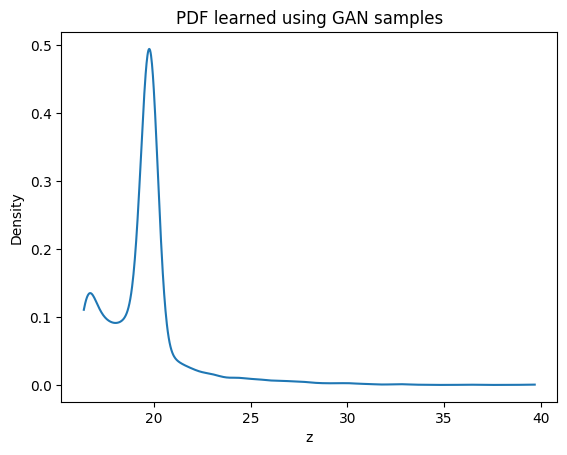

In [9]:
"""
Assignment 2 – Learning PDF using GAN 
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

import torch
import torch.nn as nn
import torch.optim as optim




data = pd.read_csv("data.csv", encoding="latin1", low_memory=False)
x_vals = pd.to_numeric(data["no2"], errors="coerce").dropna().values.reshape(-1, 1)


r = 102313049


a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

z_vals = x_vals + a_r * np.sin(b_r * x_vals)




scaler = MinMaxScaler(feature_range=(-1, 1))
z_scaled = scaler.fit_transform(z_vals)
z_tensor = torch.tensor(z_scaled, dtype=torch.float32)




class PDFGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, noise):
        x = torch.tanh(self.fc1(noise))
        x = torch.tanh(self.fc2(x))
        return self.fc3(x)




class PDFDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, sample):
        x = torch.relu(self.fc1(sample))
        return torch.sigmoid(self.fc2(x))


gen = PDFGenerator()
disc = PDFDiscriminator()

loss_fn = nn.BCELoss()
gen_opt = optim.Adam(gen.parameters(), lr=0.0008)
disc_opt = optim.Adam(disc.parameters(), lr=0.0008)




epochs = 2500
batch = 64

for ep in range(epochs):

 
    idx = np.random.choice(len(z_tensor), batch, replace=False)
    real_batch = z_tensor[idx]

    noise = torch.randn(batch, 1)
    fake_batch = gen(noise)

    real_targets = torch.ones(batch, 1)
    fake_targets = torch.zeros(batch, 1)

    disc_loss = (
        loss_fn(disc(real_batch), real_targets)
        + loss_fn(disc(fake_batch.detach()), fake_targets)
    )

    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()

  
    noise = torch.randn(batch, 1)
    fake_batch = gen(noise)

    gen_loss = loss_fn(disc(fake_batch), real_targets)

    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()

    if ep % 500 == 0:
        print(f"Epoch {ep} | D Loss: {disc_loss.item():.4f} | G Loss: {gen_loss.item():.4f}")




with torch.no_grad():
    generated_scaled = gen(torch.randn(6000, 1)).numpy()

generated_z = scaler.inverse_transform(generated_scaled).flatten()
real_z = z_vals.flatten()




kde_gen = gaussian_kde(generated_z)

z_axis = np.linspace(generated_z.min(), generated_z.max(), 1000)

plt.plot(z_axis, kde_gen(z_axis))
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF learned using GAN samples")
plt.show()

In [10]:
print("=== Transformation Parameters ===")
print(f"a_r = {a_r}")
print(f"b_r = {b_r}")


=== Transformation Parameters ===
a_r = 3.0
b_r = 1.5
